# Check GPU availability

In [1]:
# Add to your first cell to suppress oneDNN warnings
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Reduce TensorFlow logging

import tensorflow as tf

# Check GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✓ GPU Available: {len(gpus)} GPU(s) found")
    for gpu in gpus:
        print(f"  - {gpu}")
else:
    print("✗ No GPU found. Training will use CPU.")
    print("\nTo enable GPU:")
    print("1. Run: pip install tensorflow[and-cuda]==2.15.0")
    print("2. Restart kernel")

✓ GPU Available: 1 GPU(s) found
  - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# Load dataset

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Define paths
base_dir = 'data/1/kagglecatsanddogs_3367a/PetImages'

# Image parameters
IMAGE_HEIGHT, IMAGE_WIDTH = 128, 128
batch_size = 32

In [4]:
# Create ImageDataGenerator with data augmentation and validation split
train_datagen = ImageDataGenerator(
    rescale=1./255,           # Normalize pixel values to [0, 1]
    validation_split=0.2,     # Use 20% of data for validation
    rotation_range=20,        # Randomly rotate images
    width_shift_range=0.2,    # Randomly shift images horizontally
    height_shift_range=0.2,   # Randomly shift images vertically
    shear_range=0.2,          # Shear transformations
    zoom_range=0.2,           # Random zoom
    horizontal_flip=True,     # Randomly flip images horizontally
    fill_mode='nearest'       # Fill in newly created pixels
)

# Load training data
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=batch_size,      
    class_mode='binary',      # Binary classification (cat vs dog)
    subset='training',        # Use training subset
    seed=42         # Seed for reproducibility
)

# Load validation data (no augmentation, only rescaling)
val_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',      # Use validation subset
    seed=42
)

# Display dataset information
print(f"\nTraining samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")
print(f"Class indices: {train_generator.class_indices}")
print(f"Number of batches in training: {len(train_generator)}")
print(f"Number of batches in validation: {len(val_generator)}")

Found 19968 images belonging to 2 classes.
Found 4991 images belonging to 2 classes.

Training samples: 19968
Validation samples: 4991
Class indices: {'Cat': 0, 'Dog': 1}
Number of batches in training: 624
Number of batches in validation: 156



Sample Training Images:


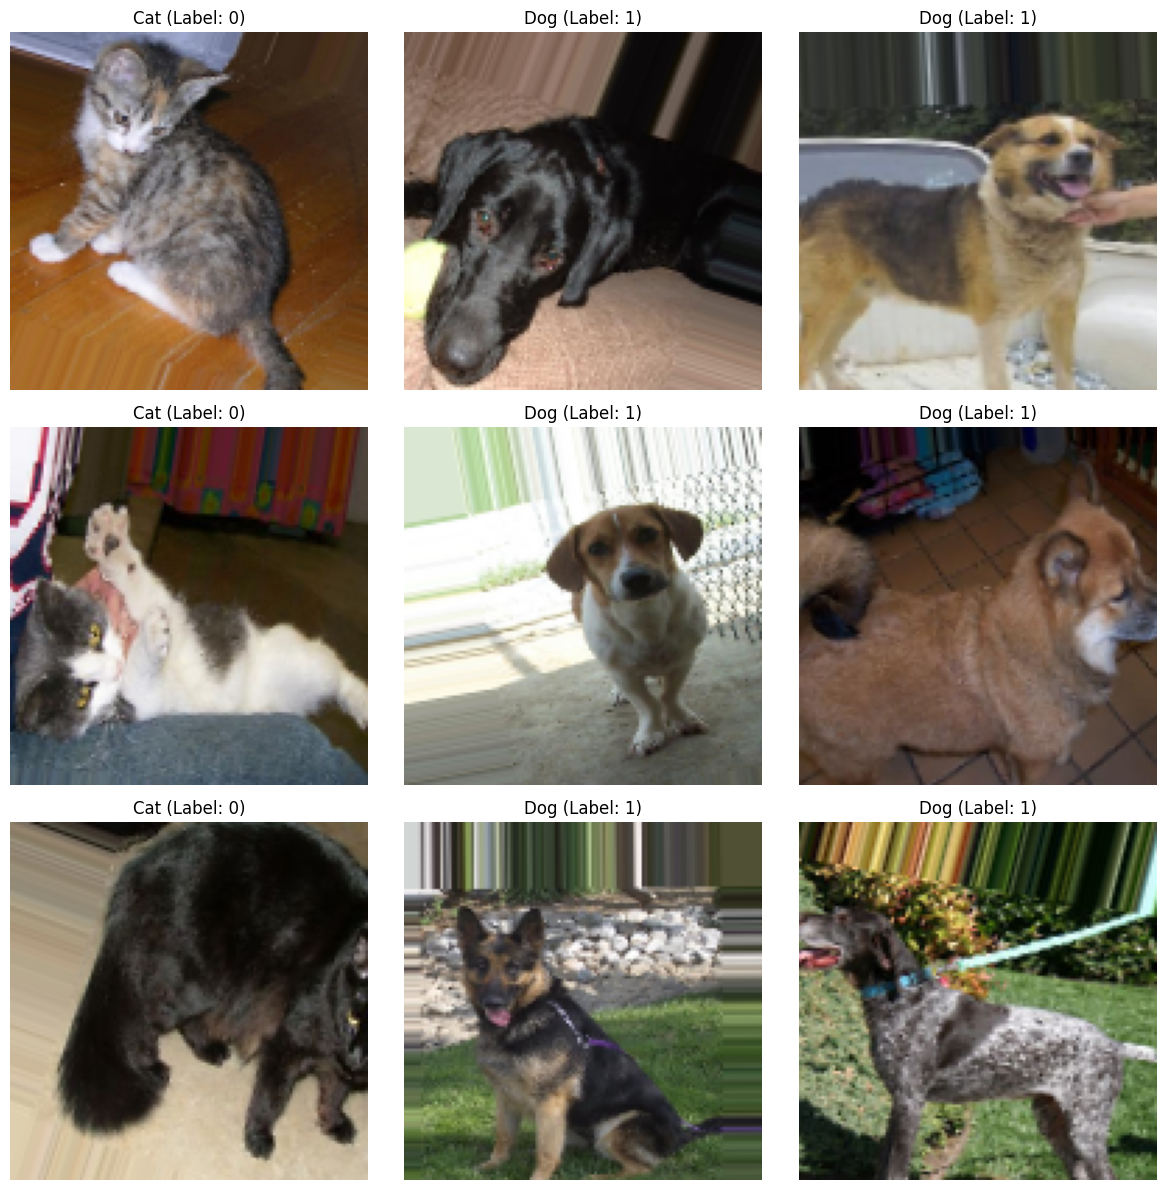

In [5]:
# Visualize sample images from the dataset
def visualize_samples(generator, num_images=9):
    """Display sample images from the generator"""
    plt.figure(figsize=(12, 12))
    
    # Get a batch of images
    images, labels = next(generator)
    
    for i in range(min(num_images, len(images))):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        # Map label to class name
        class_name = 'Cat' if labels[i] == 0 else 'Dog'
        plt.title(f'{class_name} (Label: {int(labels[i])})')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize training samples
print("\nSample Training Images:")
visualize_samples(train_generator)

# Neural Network for Cat vs Dog classification

In [ ]:
from tensorflow.keras import layers, models

input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)

# CNN model
model = models.Sequential([
    # First convolutional block - 32 filters
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Second convolutional block - 64 filters
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Third convolutional block - 128 filters
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Fourth convolutional block - 256 filters
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Flatten and fully connected layers
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])


# Display model architecture
model.summary()

# Compile the model
lr = 0.001
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr),
    loss='binary_crossentropy',  # For binary classification
    metrics=['accuracy']
)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_52 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_33 (Bat  (None, 128, 128, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_53 (Conv2D)          (None, 128, 128, 32)      9248      
                                                                 
 batch_normalization_34 (Bat  (None, 128, 128, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                     

# Train model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

# Save best model during training
checkpoint = ModelCheckpoint(
    'models/model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

EPOCHS = 50

history = model.fit(
    train_generator,
    epochs = EPOCHS,
    validation_data = val_generator,
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose = True
)

print("\n✓ Best model saved as 'models/model.keras'")

Epoch 1/50
624/624 [==============================] - ETA: 0s - loss: 0.7062 - accuracy: 0.6263
Epoch 1: val_accuracy improved from -inf to 0.62773, saving model to best_cat_dog_model.keras
624/624 [==============================] - 174s 276ms/step - loss: 0.7062 - accuracy: 0.6263 - val_loss: 0.6418 - val_accuracy: 0.6277 - lr: 0.0010
Epoch 2/50
624/624 [==============================] - ETA: 0s - loss: 0.5724 - accuracy: 0.7074
Epoch 2: val_accuracy improved from 0.62773 to 0.72831, saving model to best_cat_dog_model.keras
624/624 [==============================] - 163s 262ms/step - loss: 0.5724 - accuracy: 0.7074 - val_loss: 0.5304 - val_accuracy: 0.7283 - lr: 0.0010
Epoch 3/50
624/624 [==============================] - ETA: 0s - loss: 0.5204 - accuracy: 0.7409
Epoch 3: val_accuracy did not improve from 0.72831
624/624 [==============================] - 166s 266ms/step - loss: 0.5204 - accuracy: 0.7409 - val_loss: 0.7934 - val_accuracy: 0.6005 - lr: 0.0010
Epoch 4/50
624/624 [======

# Training result visualization

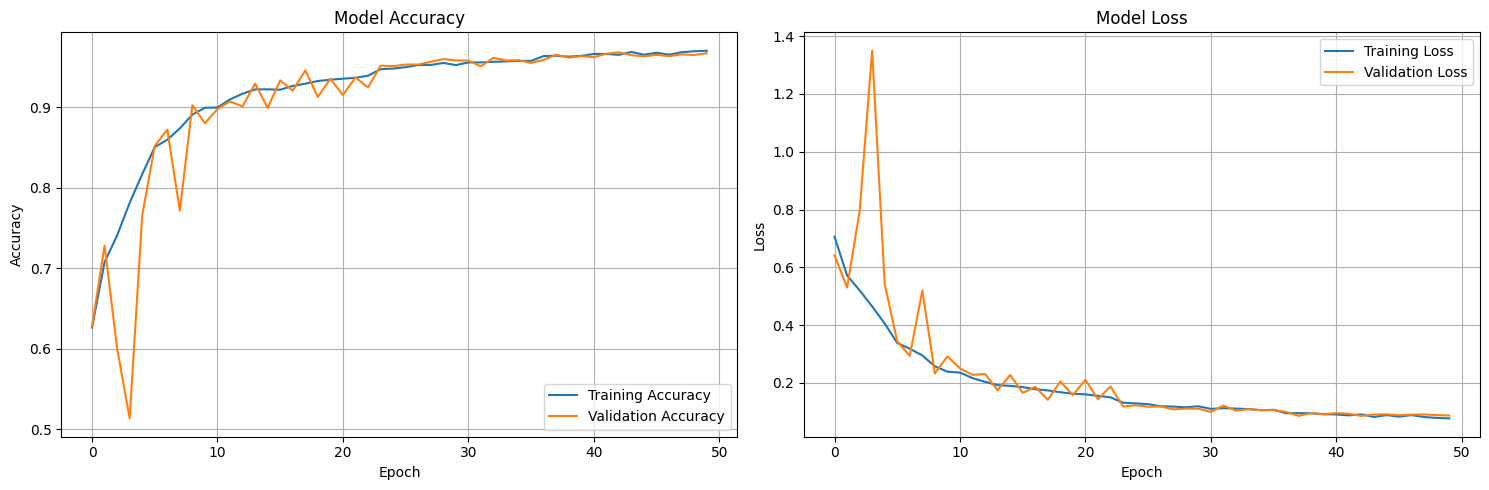


Final Training Accuracy: 0.9703
Final Validation Accuracy: 0.9671
Final Training Loss: 0.0777
Final Validation Loss: 0.0874


In [27]:
def plot_training_history(history):
    """Plot training and validation accuracy/loss"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)
    
    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

# Visualize training history
plot_training_history(history)

# Print final results
print(f"\nFinal Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")